In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt


**Load the main image**

In [3]:
main_image = cv2.imread('/content/drive/MyDrive/HIRL research/bit wise and/308_main.jpg')

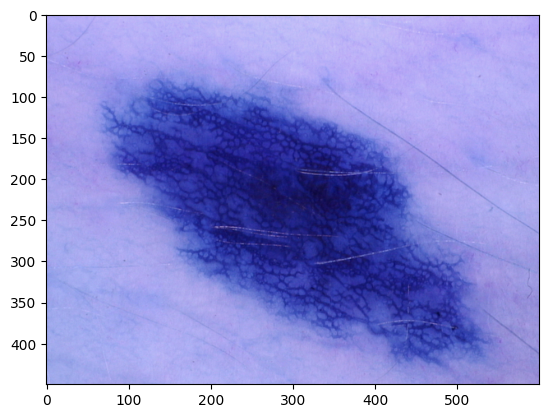

In [4]:
# Display the image
plt.imshow(main_image)

**Loading the mask image**

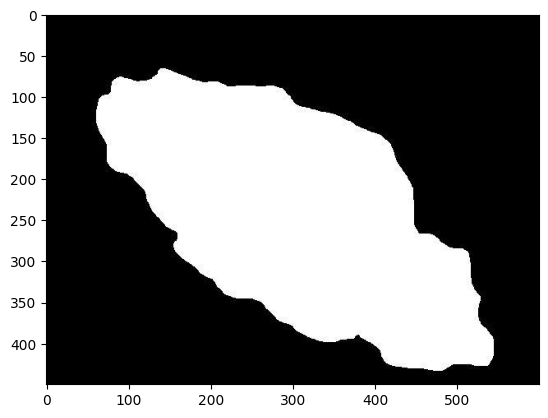

In [5]:
mask_image = cv2.imread('/content/drive/MyDrive/HIRL research/bit wise and/308_mask.png')


# Display the image
plt.imshow(mask_image)

**Perform bitwise and operation**

In [6]:
# Perform bitwise AND operation
segmented_image = cv2.bitwise_and(main_image, mask_image)


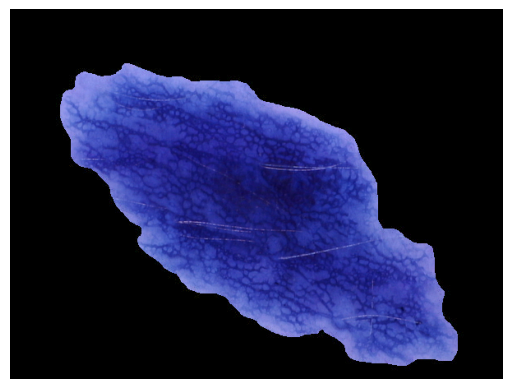

In [7]:
# Display the segmented image
plt.imshow(segmented_image)
plt.axis('off')  # Hide axes
plt.show()

In [8]:
print(type(segmented_image))

<class 'numpy.ndarray'>


**check image is rgb or not**

In [9]:

# Check if the Segmented image is in RGB format
if len(segmented_image.shape) == 3 and segmented_image.shape[2] == 3:
    print("Segmented image is in RGB format.")
else:
    print("Segmented image is not in RGB format.")


Segmented image is in RGB format.


In [10]:

# Check if the main image is in RGB format
if len(main_image.shape) == 3 and main_image.shape[2] == 3:
    print("Main image is in RGB format.")
else:
    print("Main image is not in RGB format.")

Main image is in RGB format.


In [11]:

# Check if the mask image is in RGB format
if len(mask_image.shape) == 3 and mask_image.shape[2] == 3:
    print("mask image is in RGB format.")
else:
    print("maskimage is not in RGB format.")

mask image is in RGB format.


**Show main image,mask image and segmented image in one row**

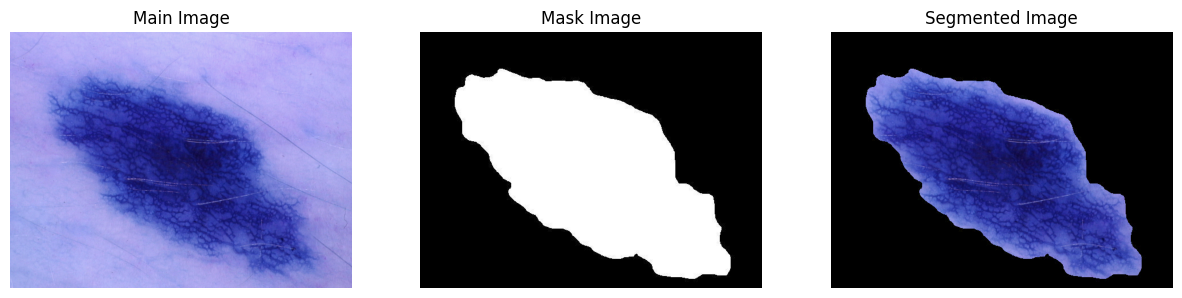

In [12]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the main image
axes[0].imshow(main_image)
axes[0].axis('off')
axes[0].set_title('Main Image')

# Plot the mask image
axes[1].imshow(mask_image)
axes[1].axis('off')
axes[1].set_title('Mask Image')

# Plot the segmented image
axes[2].imshow(segmented_image)
axes[2].axis('off')
axes[2].set_title('Segmented Image')

plt.show()


**Save Segmented image**

In [13]:
import cv2

# Assuming segmented_image is your segmented image array

# Save the segmented image to disk
cv2.imwrite('segmented_image.jpg', segmented_image)


True

**Check image dimension**

In [14]:

# Check if the image is 2D or 3D
if len(segmented_image.shape) == 2:
    print("The image is 2D.")
elif len(segmented_image.shape) == 3:
    print("The image is 3D.")
else:
    print("The image is neither 2D nor 3D.")


The image is 3D.


**Implement 3D point cloud in segmented image**

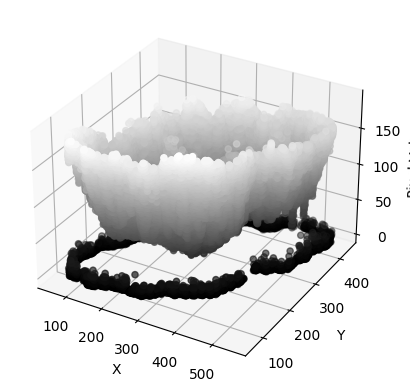

In [15]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D


# Load the 3D image
image = cv2.imread('/content/segmented_image.jpg', cv2.IMREAD_GRAYSCALE)

# Get non-zero coordinates and their corresponding pixel values
nonzero_coords = np.argwhere(image > 0)
pixel_values = image[image > 0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(nonzero_coords[:, 1], nonzero_coords[:, 0], pixel_values, c=pixel_values, cmap='gray')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Pixel Value')

# Show the plot
plt.show()



In [16]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [17]:
! pip install plotly -q

In [18]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 57 (delta 1), reused 1 (delta 1), pack-reused 50
Receiving objects: 100% (57/57), 1.56 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [19]:
%cd point-e

/content/point-e


In [20]:
! pip install -e . -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.2 MB/s eta 0:00:00


**Imports**

In [21]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

**Moddel**

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 105MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [23]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [26]:


# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[segmented_image]))):
    samples = x

0it [00:00, ?it/s]

In [28]:
segmented_image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [29]:
pc = sampler.output_to_point_clouds(samples)[0]

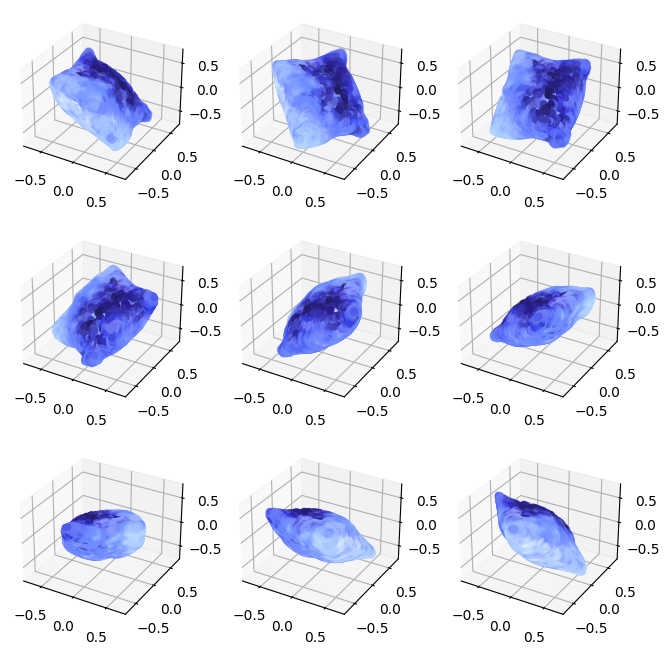

In [30]:

fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [32]:
import plotly.graph_objects as go


In [33]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [34]:
fig_plotly.show(renderer="colab")
